In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.datasets import mnist

import tensorflow as tf
import math


/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
!conda update h5py

Solving environment: done

# All requested packages already installed.



In [4]:
# train=pd.read_csv('train.csv')
# test=pd.read_csv('test.csv')

# ytrain=train['label']
# xtrain=train.drop(['label'],axis=1)


In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [6]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)


In [7]:
x_train=x_train.reshape((-1,28,28,1))
x_test=x_test.reshape((-1,28,28,1))

In [8]:
#rescaling
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train/=255.0
x_test/=255.0

In [9]:
xtr,xval,ytr,yval=train_test_split(x_train,y_train,test_size=0.1,random_state=2)#0.3 test size try that too
#but this can also cause errors by causing overfitting

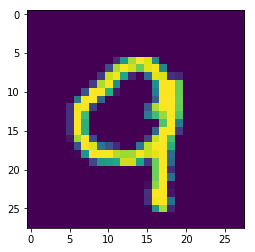

In [10]:
plt.imshow(xtr[99][:,:,0])

In [18]:
tf.reset_default_graph()


X = tf.placeholder(tf.float32, [None, 28, 28, 1])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def mnist_model(X,y,is_training):
    
    conv1=tf.layers.conv2d(inputs=X,filters=32,kernel_size=[5,5],padding='same',activation=tf.nn.relu)
    conv2=tf.layers.conv2d(inputs=conv1,filters=32,kernel_size=[5,5],padding='same',activation=tf.nn.relu)
    pool1=tf.layers.max_pooling2d(inputs=conv2,pool_size=[2,2],strides=2)
    
    layer_flat=tf.contrib.layers.flatten(pool1)
    
    dense1=tf.contrib.layers.fully_connected(layer_flat,num_outputs=64,activation_fn=tf.nn.relu)#class scores which
    
    y_out=tf.contrib.layers.fully_connected(dense1,num_outputs=10,activation_fn=None)
    
    return y_out       
    
y_out = mnist_model(X,y,is_training)

mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=(tf.one_hot(y,10)),logits=y_out))
#y is the real value and y_out is the predicted

#the y_out is a class score converted to 10 outputs which can be processed in to calcualate the softmax loss.
#Now the softmax loss and softmax classifier are two really separate things.
#this is loss calcualating using correct labels and predictions

optimizer=tf.train.RMSPropOptimizer(1e-3)

train_step=optimizer.minimize(mean_loss)#gradient changes are performed with this

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)


In [19]:
def run_model(session,predict,loss_val,Xd,yd,epochs=1,batch_size=64,print_every=100,training=None,plot_losses=False):
    
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    prediction=tf.argmax(predict,1)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    #variables = [mean_loss,correct_prediction,accuracy]
    variables = [mean_loss,correct_prediction,prediction]
    
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        y_pred= []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, prediction = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            y_pred.append(prediction)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct,y_pred
            
            
    
    

In [20]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())

print("training")
_,_,_=run_model(sess,y_out,mean_loss,xtr,ytr,5,64,200,train_step)

        

training
Iteration 0: with minibatch training loss = 2.31 and accuracy of 0.062
Iteration 200: with minibatch training loss = 0.181 and accuracy of 0.94
Iteration 400: with minibatch training loss = 0.171 and accuracy of 0.97
Iteration 600: with minibatch training loss = 0.0125 and accuracy of 1
Iteration 800: with minibatch training loss = 0.0543 and accuracy of 0.98
Epoch 1, Overall loss = 0.349 and accuracy of 0.884
Iteration 1000: with minibatch training loss = 0.227 and accuracy of 0.98
Iteration 1200: with minibatch training loss = 0.0813 and accuracy of 0.98
Iteration 1400: with minibatch training loss = 0.00573 and accuracy of 1
Iteration 1600: with minibatch training loss = 0.00103 and accuracy of 1
Epoch 2, Overall loss = 0.0437 and accuracy of 0.987
Iteration 1800: with minibatch training loss = 0.0378 and accuracy of 0.98
Iteration 2000: with minibatch training loss = 0.00953 and accuracy of 1
Iteration 2200: with minibatch training loss = 0.0327 and accuracy of 0.98
Iterat

In [21]:

print("validation")
_,_,_=run_model(sess,y_out,mean_loss,xval,yval,1,64)

validation
Epoch 1, Overall loss = 0.0495 and accuracy of 0.99


In [22]:

print("testing")
_,_,y_pred=run_model(sess,y_out,mean_loss,x_test,y_test,1,64)
    

testing
Epoch 1, Overall loss = 0.0403 and accuracy of 0.99
